<a href="https://colab.research.google.com/github/realyou0312/DACON_CreditAI/blob/main/0507_ID%EC%B6%94%EA%B0%80_%EC%BD%94%EB%93%9C%EC%88%98%EC%A0%95%ED%9B%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost
!pip install category_encoders

     |████████████████████████████████| 67.3MB 84kB/s 
     |████████████████████████████████| 81kB 4.6MB/s 


In [164]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

# import optuna
# from optuna import Trial
# from optuna.samplers import TPESampler

In [165]:
path = '/content/drive/MyDrive/DACON_Credit/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [166]:
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
train.fillna('NaN', inplace=True) 

test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.fillna('NaN', inplace=True)


In [167]:
train["DAYS_EMPLOYED"] = train["DAYS_EMPLOYED"].map(lambda x: 0 if x > 0 else x)
test["DAYS_EMPLOYED"] = test["DAYS_EMPLOYED"].map(lambda x: 0 if x > 0 else x)

In [168]:
train = train[(train['family_size'] <= 7)]
# train.set_index('index', inplace=True)
train = train.reset_index(drop=True)

In [169]:
# train_corr = train.corr()
# ax = plt.subplots(figsize=(30, 25))
# ax = sns.heatmap(train_corr, center=0, annot = True, linewidths=.5)

### 음수값 -> 양수 변환

In [170]:
feats = ['DAYS_BIRTH', 'begin_month', 'DAYS_EMPLOYED']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

In [171]:
# fig, axes = plt.subplots(1, 3, figsize=(12, 4))
# train['begin_month'][train['credit']==0].hist(bins=25, ax=axes[0])
# train['begin_month'][train['credit']==1].hist(bins=25, ax=axes[1])
# train['begin_month'][train['credit']==2].hist(bins=25, ax=axes[2])


In [172]:
# train['begin_month_level'] = pd.qcut(train['begin_month'], q=8, labels=['A','B','C','D','E','F','G','H'])
# test['begin_month_level'] = pd.qcut(test['begin_month'], q=8, labels=['A','B','C','D','E','F','G','H'])
# train['begin_month_level'] = train['begin_month_level'].astype('object')

### Feature Engineering

In [173]:
for df in [train,test]:
    #df['DAYS_BIRTH_DAYS_EMPLOYED_ratio'] = np.floor(df['DAYS_EMPLOYED'] / df['DAYS_BIRTH'])
    # df['income_total_DAYS_BIRTH_ratio'] = np.floor(df['income_total'] / df['DAYS_BIRTH'])
    #df['income_total_DAYS_EMPLOYED_ratio'] = np.floor(df['income_total'] / df['DAYS_EMPLOYED'])
    #df['parents'] = df['family_size'] - df['child_num']
    df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
    df['income_total_workingday_ratio'] = df['income_total'] / df['before_EMPLOYED']
    
    df["Age"] = df["DAYS_BIRTH"] // 365
    df["DAYS_BIRTH_m"] = np.floor(df["DAYS_BIRTH"] / 30) - ((np.floor(df["DAYS_BIRTH"] / 30) / 12).astype(int) * 12)
    df["DAYS_BIRTH_w"] = np.floor(df["DAYS_BIRTH"] / 7) - ((np.floor(df["DAYS_BIRTH"] / 7) / 4).astype(int) * 4)

    
    df["before_EMPLOYED_m"] = np.floor(df["before_EMPLOYED"] / 30) - ((np.floor(df["before_EMPLOYED"] / 30) / 12).astype(int) * 12)
    df["before_EMPLOYED_w"] = np.floor(df["before_EMPLOYED"] / 7) - ((np.floor(df["before_EMPLOYED"] / 7) / 4).astype(int) * 4)
    
    df["DAYS_EMPLOYED_m"] = np.floor(df["DAYS_EMPLOYED"] / 30) - ((np.floor(df["DAYS_EMPLOYED"] / 30) / 12).astype(int) * 12)
    df["DAYS_EMPLOYED_w"] = np.floor(df["DAYS_EMPLOYED"] / 7) - ((np.floor(df["DAYS_EMPLOYED"] / 7) / 4).astype(int) * 4)
    df["EMPLOYED"] = df["DAYS_EMPLOYED"] // 365
#     df['EMPLOYED_begin_month_ratio'] = np.floor(df['begin_month'] / (df["DAYS_EMPLOYED"]) / 30)

    df['ability'] = df['income_total'] / (df['DAYS_BIRTH'] + df['DAYS_EMPLOYED'])

    df['income_mean'] = df['income_total'] / df['family_size']
    
    df['GCR'] = (df['gender'].astype(str) + "_" + df['car'].astype(str) + "_" + df['reality'].astype(str))


In [174]:
train['ID'] = \
train['child_num'].astype(str) + '_' + train['income_total'].astype(str) + '_' +\
train['DAYS_BIRTH'].astype(str) + '_' + train['DAYS_EMPLOYED'].astype(str) + '_' +\
train['work_phone'].astype(str) + '_' + train['phone'].astype(str) + '_' +\
train['email'].astype(str) + '_' + train['family_size'].astype(str) + '_' +\
train['gender'].astype(str) + '_' + train['car'].astype(str) + '_' +\
train['reality'].astype(str) + '_' + train['income_type'].astype(str) + '_' +\
train['edu_type'].astype(str) + '_' + train['family_type'].astype(str) + '_' +\
train['house_type'].astype(str) + '_' + train['occyp_type'].astype(str)

test['ID'] = \
test['child_num'].astype(str) + '_' + test['income_total'].astype(str) + '_' +\
test['DAYS_BIRTH'].astype(str) + '_' + test['DAYS_EMPLOYED'].astype(str) + '_' +\
test['work_phone'].astype(str) + '_' + test['phone'].astype(str) + '_' +\
test['email'].astype(str) + '_' + test['family_size'].astype(str) + '_' +\
test['gender'].astype(str) + '_' + test['car'].astype(str) + '_' +\
test['reality'].astype(str) + '_' + test['income_type'].astype(str) + '_' +\
test['edu_type'].astype(str) + '_' + test['family_type'].astype(str) + '_' +\
test['house_type'].astype(str) + '_' + test['occyp_type'].astype(str)

In [94]:
# for df in [train,test]:
#     df["contact"] = df["email"].astype(str)+df["phone"].astype(str)+ df["work_phone"].astype(str)
#     df["info"] = df["gender"].astype(str)+df["occyp_type"].astype(str)+ df["edu_type"].astype(str)
# ID_columns = ["contact", "info"]
# for feat in ID_columns:
#     order= train[feat][train["credit"]==2].value_counts(normalize= True, sort= True).index
#     mapping = {}
#     for index, value in enumerate(order):
#         mapping[value]= index
#     train[feat] = train[feat].map(mapping)
#     test[feat] = test[feat].map(mapping)

In [62]:
# for df in [train,test]:
    
#    df["contact"] = df["email"].astype(str) + '-' + df["phone"].astype(str) + '-' + df["work_phone"].astype(str)


In [15]:
#train.sort_values(by=['index'], axis=0, inplace=True, ignore_index=True)
#test.sort_values(by=['index'], axis=0, inplace=True, ignore_index=True)

In [16]:
#train.drop(['ID'], axis=1, inplace=True)
#test.drop(['ID'], axis=1, inplace=True)

In [17]:
#new_data=pd.DataFrame(train.groupby(["ID"])["begin_month"].agg(min))
#new_data

### 사용한, 중요도 낮은 컬럼 삭제

In [175]:
del_cols = [
     'gender',
     'car',
     'reality',
    'child_num',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
#    'email',
#    'parents',
#     'phone',
#     'work_phone'
#     'before_EMPLOYED',
#     'ability',
    #'income_type', 'edu_type', 'family_size', 'phone', 'house_type', 'work_phone', 
#     'G_C_R'

]

train.drop(del_cols, axis=1, inplace=True)
test.drop(del_cols, axis=1, inplace=True)

In [176]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
# numerical_feats.remove('ID')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

total_feats = numerical_feats + categorical_feats

Number of Numerical features:  18
Number of Categorical features:  7


## LabelEncoding, Scaling

In [177]:
categorical_feats

['income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type',
 'GCR',
 'ID']

In [178]:
# for df in [train,test]:
# #     df['gender'] = df.groupby(['gender'])['index'].transform('count')
# #     df['car'] = df.groupby(['car'])['index'].transform('count')
# #     df['reality'] = df.groupby(['reality'])['index'].transform('count')
# #     df['phone'] = df.groupby(['phone'])['index'].transform('count')
# #     df['work_phone'] = df.groupby(['work_phone'])['index'].transform('count')
# #     df['email'] = df.groupby(['email'])['index'].transform('count')
#     df['ID'] = df.groupby(['ID'])['index'].transform('count')
#     df['GCR'] = df.groupby(['GCR'])['index'].transform('count')
#     df['income_type'] = df.groupby(['income_type'])['index'].transform('count')
#     df['edu_type'] = df.groupby(['edu_type'])['index'].transform('count')
#     df['family_type'] = df.groupby(['family_type'])['index'].transform('count')
#     df['house_type'] = df.groupby(['house_type'])['index'].transform('count')
#     df['occyp_type'] = df.groupby(['occyp_type'])['index'].transform('count')


In [179]:
for df in [train,test]:
    df['income_total'] = np.log1p(1+df['income_total'])
    


In [180]:
# for feat in categorical_feats:
#     encoder = LabelEncoder()
#     train[feat] = encoder.fit_transform(train[feat])
#     test[feat] = encoder.transform(test[feat])

In [181]:
from category_encoders.ordinal import OrdinalEncoder
encoder = OrdinalEncoder(categorical_feats)
train[categorical_feats] = encoder.fit_transform(train[categorical_feats], train['credit'])
test[categorical_feats] = encoder.transform(test[categorical_feats])



In [182]:
kmeans_train = train.drop(['credit'], axis=1)
kmeans = KMeans(n_clusters=36, random_state=42).fit(kmeans_train)
train['kmeans_clusters'] = kmeans.predict(kmeans_train)
test['kmeans_clusters'] = kmeans.predict(test)

scaler = StandardScaler()
kmeans_train = scaler.fit_transform(kmeans_train)

In [183]:
#numerical_feats.remove('begin_month')
#numerical_feats.remove('age_groups')
numerical_feats.remove('income_total')
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])


In [27]:
# fig, ax = plt.subplots(figsize=(18, 15))
# sns.scatterplot(x="EMPLOYED", y="income_total", hue="", data=train)
# plt.show()

In [28]:

# fig, ax = plt.subplots(figsize=(18, 15))
# sns.histplot(train["income_total"], kde=True)
# plt.show()

## Modeling

In [184]:
n_est = 2000
seed = 42
n_fold = 10
n_class = 3

target = 'credit'
X = train.drop(target, axis=1)
y = train[target]
X_test = test

In [185]:
lgb_params = {
                    'objective':'multiclass',
                    'num_class': n_class,
                    'boosting_type':'gbdt',
                    'metric':'multi_logloss',
                    'n_jobs':-1,
                    'learning_rate':0.02,
                    'num_leaves': 128,
                    'max_depth':15,
                    'tree_learner':'serial',
                    "min_child_weight": 0.01,
                    'colsample_bytree': 0.7,
                    'subsample_freq':1,
                    'subsample':0.5,
                    'n_estimators':n_est,
                    'max_bin':800,
                    'verbose':-1,
                    'seed': seed,
                    #'early_stopping_rounds':300, 
                }


### Model : LGBM

In [186]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))


lgb_pred = np.zeros((X.shape[0], n_class), dtype=float)
lgb_pred_test = np.zeros((X_test.shape[0], n_class), dtype=float)
for fold in range(n_fold):
  print(f"----------------- Fold {fold} -----------------\n")
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  model_lgbm = LGBMClassifier(**lgb_params)
  model_lgbm.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            early_stopping_rounds=100,
            verbose=100,)
  lgb_pred[valid_idx] = model_lgbm.predict_proba(X_valid)
  lgb_pred_test += model_lgbm.predict_proba(X_test) / n_fold
    

print(f'\tLog Loss: {log_loss(y, lgb_pred):.6f}')

----------------- Fold 0 -----------------

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.68126	valid_1's multi_logloss: 0.753879
[200]	training's multi_logloss: 0.587037	valid_1's multi_logloss: 0.713006
[300]	training's multi_logloss: 0.523448	valid_1's multi_logloss: 0.693302
[400]	training's multi_logloss: 0.474998	valid_1's multi_logloss: 0.68223
[500]	training's multi_logloss: 0.435578	valid_1's multi_logloss: 0.676858
[600]	training's multi_logloss: 0.403314	valid_1's multi_logloss: 0.674677
Early stopping, best iteration is:
[594]	training's multi_logloss: 0.40517	valid_1's multi_logloss: 0.674378
----------------- Fold 1 -----------------

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.680737	valid_1's multi_logloss: 0.76317
[200]	training's multi_logloss: 0.586304	valid_1's multi_logloss: 0.724271
[300]	training's multi_logloss: 0.522932	valid_1's multi_logloss: 0.704033
[400]

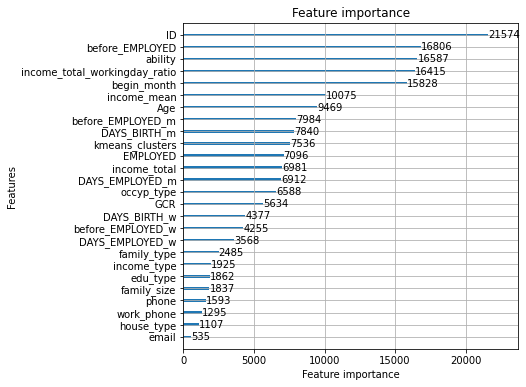

In [187]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline


f, ax = plt.subplots(figsize=(6, 6))
plot_importance(model_lgbm, ax=ax, max_num_features=len(X_test.columns))
#plt.savefig('Feature importance_0507.png')

In [188]:
lgb_preds_df = pd.DataFrame(lgb_pred_test)
lgb_preds_df.to_csv("lgbm_kmeans.csv")

In [34]:
# perm = PermutationImportance(model_lgbm, random_state=42).fit(X_train, y_train)


In [35]:
# eli5.show_weights(perm, feature_names = X_train.columns.tolist())

### Model : RF

In [189]:
rf_params = {
        'criterion': 'gini',
        'n_estimators': 1200,
        'min_samples_split': 10,
        'min_samples_leaf': 1,
        'max_features': 'auto',
        'oob_score': True,
        'random_state': seed,
        'n_jobs': -1,
}

In [190]:


skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))


rf_pred = np.zeros((X.shape[0], n_class), dtype=float)
rf_pred_test = np.zeros((X_test.shape[0], n_class), dtype=float)
for fold in range(n_fold):
  print(f"----------------- Fold {fold} -----------------\n")
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  model_rf = RandomForestClassifier(**rf_params)
  model_rf.fit(X_train, y_train,)
  rf_pred[valid_idx] = model_rf.predict_proba(X_valid)
  rf_pred_test += model_rf.predict_proba(X_test) / n_fold
  print(f"CV Log Loss: {log_loss(y_valid, rf_pred[valid_idx]):.6f}")
    
print(f'\tLog Loss: {log_loss(y, rf_pred):.6f}')


----------------- Fold 0 -----------------

CV Log Loss: 0.672218
----------------- Fold 1 -----------------

CV Log Loss: 0.675461
----------------- Fold 2 -----------------

CV Log Loss: 0.675813
----------------- Fold 3 -----------------

CV Log Loss: 0.690654
----------------- Fold 4 -----------------

CV Log Loss: 0.676310
----------------- Fold 5 -----------------

CV Log Loss: 0.707307
----------------- Fold 6 -----------------

CV Log Loss: 0.680024
----------------- Fold 7 -----------------

CV Log Loss: 0.687225
----------------- Fold 8 -----------------

CV Log Loss: 0.688357
----------------- Fold 9 -----------------

CV Log Loss: 0.694342
	Log Loss: 0.684771


In [191]:
rf_preds_df = pd.DataFrame(rf_pred_test)
rf_preds_df.to_csv("rf_kmeans.csv")

### Model : XGB

In [194]:
xgb_params = {
        "random_state": seed,
        "n_estimators": 3000,
        "objective": "multi:softmax",
        "eval_metric": "mlogloss",
        "eta": 0.01,
        # "reg_alpha": 3e-5,
        # "reg_lambda": 9e-2,
        "max_depth": 20,
        "max_leaves": 256,
        "colsample_bytree": 0.7,
        "subsample": 0.5,
        "min_child_weight": 5,
        "gamma": 0.5,
}

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))


xgb_pred = np.zeros((X.shape[0], n_class), dtype=float)
xgb_pred_test = np.zeros((X_test.shape[0], n_class), dtype=float)
for fold in range(n_fold):
  print(f"----------------- Fold {fold} -----------------\n")
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  model_xgb = XGBClassifier(**xgb_params)
  model_xgb.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_valid, y_valid)],
            early_stopping_rounds=100,
            verbose=100,)
  xgb_pred[valid_idx] = model_xgb.predict_proba(X_valid)
  xgb_pred_test += model_xgb.predict_proba(X_test) / n_fold
  print(f"CV Log Loss: {log_loss(y_valid, xgb_pred[valid_idx]):.6f}")
    
print(f'\tLog Loss: {log_loss(y, xgb_pred):.6f}')


----------------- Fold 0 -----------------

[0]	validation_0-mlogloss:1.04193	validation_1-mlogloss:1.04899
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 100 rounds.
[100]	validation_0-mlogloss:0.318342	validation_1-mlogloss:0.682881
Stopping. Best iteration:
[68]	validation_0-mlogloss:0.379848	validation_1-mlogloss:0.676093

CV Log Loss: 0.676094
----------------- Fold 1 -----------------

[0]	validation_0-mlogloss:1.05148	validation_1-mlogloss:1.05916
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 100 rounds.
[100]	validation_0-mlogloss:0.31774	validation_1-mlogloss:0.687554
Stopping. Best iteration:
[66]	validation_0-mlogloss:0.386128	validation_1-mlogloss:0.680455

CV Log Loss: 0.680454
----------------- Fold 2 -----------------

[0]	validation_0-mlogloss:1.04936	val

In [ ]:
xgb_preds_df = pd.DataFrame(xgb_pred_test)
xgb_preds_df.to_csv("xgb_kmeans.csv")

### Model : Catboost

In [41]:
cat_params = {
        "l2_leaf_reg": 0.08,
        "max_depth": 10,
        "bagging_temperature": 1,
        "min_data_in_leaf": 72,
        "max_bin": 300,
        "random_state": seed,
        "eval_metric": "MultiClass",
        "loss_function": "MultiClass",
        "learning_rate": 0.05,
        "od_type": "Iter",
        "od_wait": 500,
        "n_estimators": 5000,
        "cat_features": [
            "income_type",
            "edu_type",
            "family_type",
            "house_type",
            "occyp_type",
            "GCR",
            'ID'
        ],
    }

In [42]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))


cat_pred = np.zeros((X.shape[0], 3))
cat_pred_test = np.zeros((X_test.shape[0], 3))
cat_cols = [
        'income_type',
        'edu_type',
        'family_type',
        'house_type',
        'occyp_type',
        'GCR',
        'ID'
]
for fold in range(n_fold):
  print(f"----------------- Fold {fold} -----------------\n")
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier(**cat_params)
  model_cat.fit(train_data,
            eval_set=valid_data,
            use_best_model=True,
            early_stopping_rounds=100,
            verbose=100,)
  cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  print(f"CV Log Loss: {log_loss(y_valid, cat_pred[valid_idx]):.6f}")
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')


----------------- Fold 0 -----------------

0:	learn: 1.0870942	test: 1.0868182	best: 1.0868182 (0)	total: 118ms	remaining: 9m 49s
100:	learn: 0.8028972	test: 0.8068822	best: 0.8068822 (100)	total: 21.5s	remaining: 17m 21s
200:	learn: 0.7382715	test: 0.7789355	best: 0.7789355 (200)	total: 54.3s	remaining: 21m 35s
300:	learn: 0.6896341	test: 0.7636044	best: 0.7636044 (300)	total: 1m 32s	remaining: 23m 58s
400:	learn: 0.6480266	test: 0.7523953	best: 0.7523466 (399)	total: 2m 9s	remaining: 24m 49s
500:	learn: 0.5986124	test: 0.7372299	best: 0.7372299 (500)	total: 2m 48s	remaining: 25m 15s
600:	learn: 0.5515168	test: 0.7223995	best: 0.7223995 (600)	total: 3m 25s	remaining: 25m 2s
700:	learn: 0.5088989	test: 0.7105260	best: 0.7105260 (700)	total: 4m 1s	remaining: 24m 39s
800:	learn: 0.4698028	test: 0.7019787	best: 0.7019763 (799)	total: 4m 37s	remaining: 24m 12s
900:	learn: 0.4364800	test: 0.6960916	best: 0.6960796 (896)	total: 5m 13s	remaining: 23m 46s
1000:	learn: 0.4079065	test: 0.693502

In [ ]:
cat_preds_df = pd.DataFrame(cat_pred_test)
cat_preds_df.to_csv("cat_kmeans.csv")

In [192]:


sub = pd.read_csv(path + 'sample_submission.csv')
sub.iloc[:, 1:] = (
    lgb_pred_test * 0.5
    + xgb_pred_test * 0.2
         #+ cat_preds * 0.05
+ rf_pred_test * 0.3
)



In [47]:
sub

,index,0,1,2
0,26457,0.097152,0.226657,0.676191
1,26458,0.310147,0.278599,0.411253
2,26459,0.040656,0.068961,0.890383
3,26460,0.071918,0.077470,0.850612
4,26461,0.085618,0.170302,0.744081
...,...,...,...,...
9995,36452,0.072088,0.228379,0.699533
9996,36453,0.297233,0.290037,0.412730
9997,36454,0.028940,0.135317,0.835744
9998,36455,0.210486,0.420851,0.368662


In [193]:
sub.to_csv('submission0508_AddID_2models.csv', index=False)